# Nonparametric Differential Equations (npde)

This document describes how to use the software implementation of our **npsde** (nonparametric stochastic differential equations) model. The implementation is in python3.5 and requires __[TensorFlow(1.6.0+)](https://www.tensorflow.org/)__ and __[GPflow(1.1+)](https://github.com/GPflow/GPflow)__. To learn more about the model, __[here](https://arxiv.org/abs/1807.05748)__ is a link to the our paper to be presented in MLSP in September 2018. This repository also overrides the MATLAB implementation of **npODE** model for learning ordinary differential equations (__[here](http://proceedings.mlr.press/v80/heinonen18a/heinonen18a.pdf)__ is the npODE ICML 2018 paper and __[here](https://github.com/cagatayyildiz/npode)__ is the old MATLAB implementation).

&nbsp;

**Notebook Sections**

The notebook consists of three sections, each containing an example fit where the underlying dynamics are governed by an ODE, SDE with constant diffusion, and SDE with state dependent diffusion. Van der Pol (VDP) oscillator, whose dynamics are given by equations below, is used as the running example:
\begin{align*}
\frac{dx_1}{dt} = x_2 \qquad \qquad \frac{dx_2}{dt} &= (1-x_1^2) x_2 - x_1 
\end{align*}
In examples below, true constant diffusion is equal to 0.2 and the state dependent diffusion function is given by $g(x)=3\mathcal{N}(x;[-2,0],0.5I)$. The model is completely unaware of the dynamics, and infers the dynamics by placing Gaussian process priors over the drift and diffusion functions and computing the posterior.

&nbsp;

**Main Functions**

There are three main python functions that provide an easy-to-use interface to the model implementation:
 * ```npde_fit``` -  fits the model (ODE/SDE) to the input data and observed time points  
 * `predict` - a class function that predicts signals given a `npde` model that stores the learned SDE dynamics, an initial value and observed time points   
 * `sample` - a class function that draws samples from a learned SDE system signals given the same input in `predict` function

&nbsp;

**For Better Performance**

The quality of the fit relies on many factors including the width of the inducing point grid `W`, lengthscales `ell`, learning rate `eta`, number of optimization steps `num_iter` and number of samples `Nw` used for optimization in SDEs. Few notes about enhancing the performance: 
 * In general, a denser inducing point grid and more samples for SDEs are better - the higher `W` and `Nw`, the better. 
 * Learning rate must always be carefully tuned for every problem and even data set.
 * Higher lengthscale values result in smoother trajectories. Although optimized, we reserve it for model selection. For example in modeling constant diffusions, lengthscale of the diffusion function must be high, e.g., $10^5$. It is also a good idea to perform the optimization several times over a grid of lengthscales. For instance, a good grid in case of VDP oscillator with `W=5` would be `linspace(0.75,4,10`).
 * It should also be noted that `W` and `ell` should be tuned together carefully. In general, if one is increased, then the other should be decreased.

## Preparing the Environment

In [1]:
%load_ext autoreload
%autoreload 2

# avoid GPU due to Cholesky decompositions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.InteractiveSession()

import numpy as np
from utils import gen_data, plot_model, eval_model
from npde_helper import build_model, fit_model, save_model, load_model

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






## 1. ODE

### Data Generation

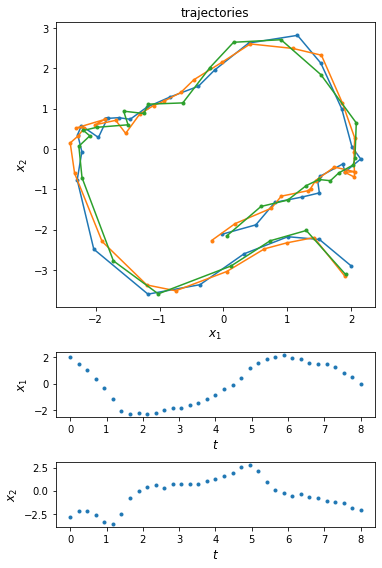

In [2]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tbegin=0, tend=8, nstd=0.1)

###  Inference

Model being initialized...



Building loss function...

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instea

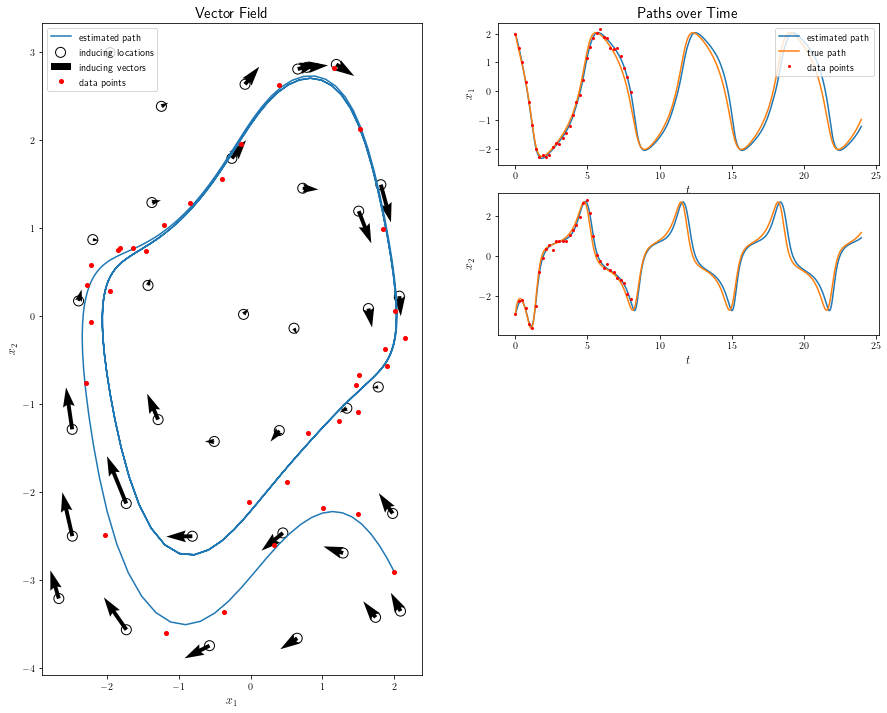

In [3]:
# t - observation times, a python array of numpy vectors
# Y - observations, a python array of numpy matrices, data points are in rows
# step size (eta) must be carefully tuned for different data sets
npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")
npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

# how to plot the model
# plot_model(npde,t,Y)

# how to save/load the model
# save_model(npde,'npde.pkl')
# npde = load_model('npde.pkl',sess)

In [4]:
eval_model(npde, t, Y, Nw=1)
eval_t = [np.linspace(0, 8, 50)]
eval_model(npde, eval_t, Y, Nw=1)


name:                  npode
noise variance:        [0.00560343 0.01294251]
signal variance:       1.5609159460364357
lengthscales:          [0.81776358 1.25431681]
RMSE over the dimensions is: 4.976216243757914
name:                  npode
noise variance:        [0.00560343 0.01294251]
signal variance:       1.5609159460364357
lengthscales:          [0.81776358 1.25431681]
RMSE over the dimensions is: 4.994427402240755


4.994427402240755

#### Restrict the start and end for time [2,4]

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         178.573
              50         123.007
             100          72.567
             150          31.926
             200          10.914
             250           4.142
             300           1.414
             350          -0.954
             400          -2.277
             450          -3.121
             500          -3.754
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.00749471 0.01258247]
signal variance:       1.4815354133745844
lengthscales:          [0.64794039 0.51866655]


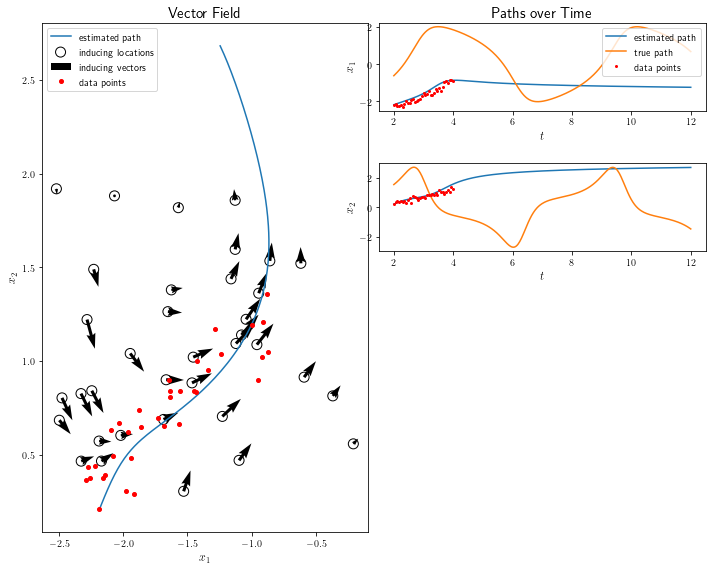

name:                  npode
noise variance:        [0.00749471 0.01258247]
signal variance:       1.4815354133745844
lengthscales:          [0.64794039 0.51866655]
RMSE over the dimensions is: 5.642168695193731
name:                  npode
noise variance:        [0.00749471 0.01258247]
signal variance:       1.4815354133745844
lengthscales:          [0.64794039 0.51866655]
RMSE over the dimensions is: 5.611875263987536


5.611875263987536

In [5]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tbegin=2, tend=4, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")
npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

eval_model(npde, t, Y, Nw=1)

eval_t = [np.linspace(0, 8, 50)]
eval_model(npde, eval_t, Y, Nw=1)

In [47]:
def get_covariance(de_model, T, sn=[]):
    Z = de_model.Z
    
    KTT = de_model.kern._vectorK(T, T)
    
    KTZ = de_model.kern._vectorK(T, Z)
    
    if len(sn) == 0:
        sn = de_model.sn
    
    sigma_matrix = tf.diag(sn).eval()
    I_for_Z = tf.eye(int(npde.Z.shape[0])).eval()
    tilde_KZZ = de_model.kern._vectorK(Z, Z) + np.kron(sigma_matrix, I_for_Z)
    
    return (KTT - KTZ @ tf.linalg.inv(tilde_KZZ) @ tf.transpose(KTZ)).eval()
    
def _get_IG(prior, posterior, jitter=1e-7):
    n = prior.shape[0]    
    return 0.5 * (np.linalg.slogdet(prior + np.eye(n)*jitter)[1] -  np.linalg.slogdet(posterior + np.eye(n)* jitter)[1])


def get_covariance_full(de_model, X, T, sn):
    KTT = de_model.kern._vectorK(T, T)
    
    KTX = de_model.kern._vectorK(T, X)
    
    sigma_matrix = tf.diag(sn).eval()
    I_for_X = tf.eye(int(X.shape[0])).eval()
    tilde_KXX = de_model.kern._vectorK(X, X) + np.kron(sigma_matrix, I_for_X)
    
    return (KTT - KTX @ tf.linalg.inv(tilde_KXX) @ tf.transpose(KTX)).eval()


In [8]:
# target
T = [[-2.32578471,  0.46516988],
       [-2.32753168,  0.82586878],
       [-2.49610293,  0.68355694],
       [-2.47536932,  0.80290642],
        [-2, 1],
        [-1, 2],
        [1, 0],
        [1.5, 2]]

Model being initialized...
Calculating prior covariance on target vs. inducing point.
Prior noise variances are [0.5 0.5].
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         178.573
              50         123.007
             100          72.567
             150          31.926
             200          10.914
             250           4.142
             300           1.414
             350          -0.954
             400          -2.277
             450          -3.121
             500          -3.754
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.00749471 0.01258247]
signal variance:       1.4815354133745844
lengthscales:          [0.64794039 0.51866655]


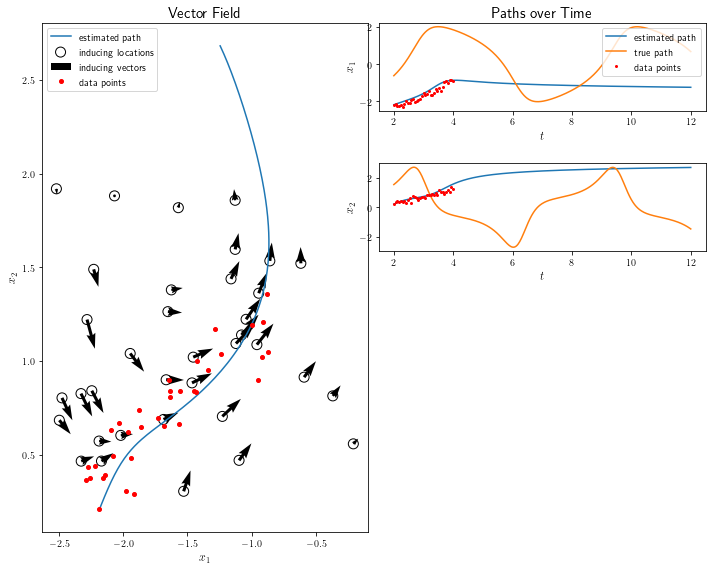

Posterior noise variances are [0.00749471 0.01258247].
Calculating posterior covariance on target vs. inducing point.


(-5.987411309530813, -8.090031722310897)

In [50]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tbegin=2, tend=4, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

# training data vs. target covariance
train_X = Y[0][:20]

print("Calculating prior covariance on target vs. inducing point.")
prior_KTZ = get_covariance(npde, T)
prior_full = get_covariance_full(npde, train_X, T, npde.sn)

prior_sn = npde.sn.eval()
print(f'Prior noise variances are {prior_sn}.')

npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

posterior_sn = npde.sn.eval()
print(f'Posterior noise variances are {posterior_sn}.')

print("Calculating posterior covariance on target vs. inducing point.")
posterior_KTZ = get_covariance(npde, T)
posterior_full = get_covariance_full(npde, train_X, T, npde.sn)

IG_2_4_trail_3 = _get_IG(prior_KTZ, posterior_KTZ)

IG_2_4_trail_3_full = _get_IG(prior_full, posterior_full)

IG_2_4_trail_3, IG_2_4_trail_3_full

In [52]:
def compute_IG(de_model, train_X, T, prior_sn, posterior_sn):
    prior_KTZ = get_covariance(npde, T, sn=prior_sn)
    prior_full = get_covariance_full(npde, train_X, T, sn=prior_sn)

    posterior_KTZ = get_covariance(npde, T, sn=posterior_sn)
    posterior_full = get_covariance_full(npde, train_X, T, sn=posterior_sn)

    IG_inducing = _get_IG(prior_KTZ, posterior_KTZ)
    IG_full = _get_IG(prior_full, posterior_full)
    
    return IG_inducing, IG_full

from collections import defaultdict

inducing_IGs = defaultdict(list)
full_IGs = defaultdict(list)

for size in [5, 10, 15, 20, -1]:
    
    train_X = Y[0][:size]
    IG_inducing, IG_full = compute_IG(npde, train_X, T, prior_sn, posterior_sn)
        
    inducing_IGs[size].append(IG_inducing)
    full_IGs[size].append(IG_full)
    
    print(f'trainX size: {size}, inducing IG: {IG_inducing}, full IG: {IG_full}')

trainX size: 5, inducing IG: 2.12921100158421, full IG: 1.8279861917797149
trainX size: 10, inducing IG: 2.12921100158421, full IG: 2.8144853851089096
trainX size: 15, inducing IG: 2.12921100158421, full IG: 1.8521341710905688
trainX size: 20, inducing IG: 2.12921100158421, full IG: 1.909106973899675
trainX size: -1, inducing IG: 2.12921100158421, full IG: 2.9322892059604158


Model being initialized...
Calculating prior covariance on target vs. inducing point.
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         180.653
              50         123.650
             100          79.295
             150          44.008
             200          22.658
             250          38.213
             300          10.289
             350           7.535
             400           5.468
             450           4.191
             500           1.626
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.00746919 0.00965154]
signal variance:       1.5667515805048284
lengthscales:          [0.73644364 0.23740518]


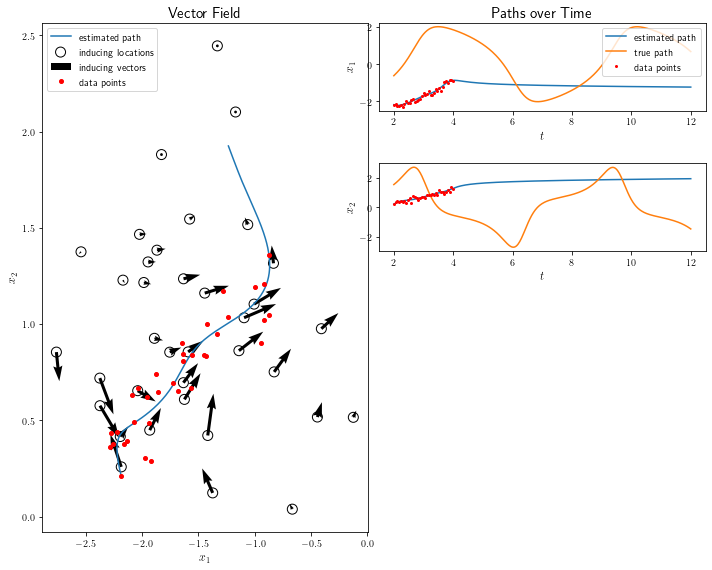

Calculating posterior covariance on target vs. inducing point.


-21.059842435951012

In [10]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35], tbegin=2, tend=4, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

print("Calculating prior covariance on target vs. inducing point.")
prior_KTZ = get_covariance(npde, T).eval()

npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

print("Calculating posterior covariance on target vs. inducing point.")
posterior_KTZ = get_covariance(npde, T).eval()

IG_2_4_trail_1 = _get_IG(prior_KTZ, posterior_KTZ)
IG_2_4_trail_1

Model being initialized...
Calculating prior covariance on target vs. inducing point.
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         170.082
              50         110.137
             100          70.143
             150          42.729
             200          26.730
             250          18.709
             300          14.026
             350          13.339
             400          16.793
             450          11.949
             500          12.830
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.00961847 0.00438099]
signal variance:       2.5106820474275415
lengthscales:          [0.84068918 1.19273731]


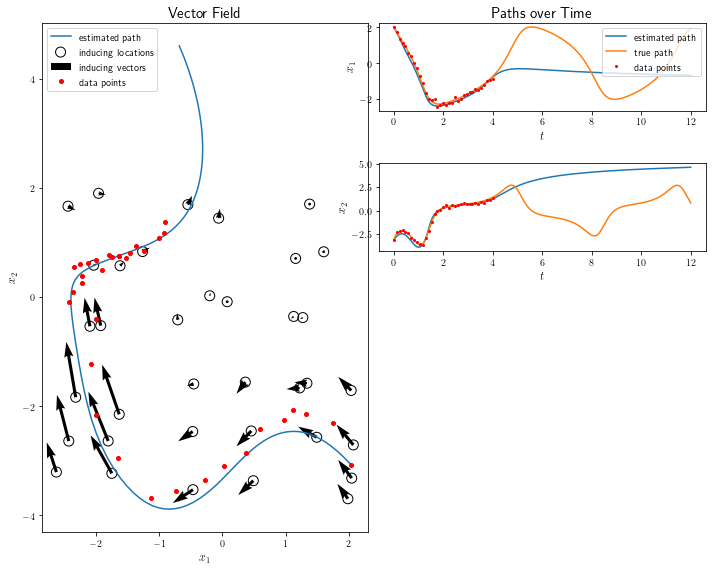

name:                  npode
noise variance:        [0.00961847 0.00438099]
signal variance:       2.5106820474275415
lengthscales:          [0.84068918 1.19273731]
RMSE over the dimensions is: 5.116224012281793
name:                  npode
noise variance:        [0.00961847 0.00438099]
signal variance:       2.5106820474275415
lengthscales:          [0.84068918 1.19273731]
RMSE over the dimensions is: 9.90125813976053
Calculating posterior covariance on target vs. inducing point.


In [11]:
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35, 40, 30], tbegin=0, tend=4, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

print("Calculating prior covariance on target vs. inducing point.")
prior_KTZ = get_covariance(npde, T).eval()

npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)
eval_model(npde, t, Y, Nw=1)

eval_t = [np.linspace(0, 8, 50)]
eval_model(npde, eval_t, Y, Nw=1)


print("Calculating posterior covariance on target vs. inducing point.")
posterior_KTZ = get_covariance(npde, T).eval()

IG_0_4_trail_3 = _get_IG(prior_KTZ, posterior_KTZ)

In [13]:
IG_0_4_trail_3

-2.9291336946185424

Model being initialized...
Calculating prior covariance on target vs. inducing point.
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         213.312
              50         134.174
             100          82.368
             150          50.332
             200          36.014
             250          32.631
             300          35.099
             350          28.650
             400          32.016
             450          26.681
             500          26.125
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.01092601 0.01488274]
signal variance:       2.5474960160267393
lengthscales:          [0.82838095 1.16757754]


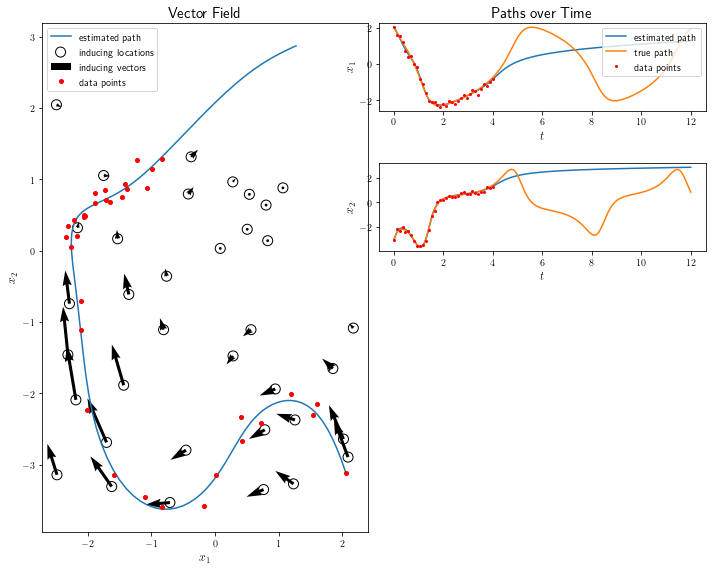

name:                  npode
noise variance:        [0.01092601 0.01488274]
signal variance:       2.5474960160267393
lengthscales:          [0.82838095 1.16757754]
RMSE over the dimensions is: 3.539249476909612
name:                  npode
noise variance:        [0.01092601 0.01488274]
signal variance:       2.5474960160267393
lengthscales:          [0.82838095 1.16757754]
RMSE over the dimensions is: 5.923008841832445
Calculating posterior covariance on target vs. inducing point.


In [12]:
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35], tbegin=0, tend=4, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

print("Calculating prior covariance on target vs. inducing point.")
prior_KTZ = get_covariance(npde, T).eval()

npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)
eval_model(npde, t, Y, Nw=1)

eval_t = [np.linspace(0, 8, 50)]
eval_model(npde, eval_t, Y, Nw=1)

print("Calculating posterior covariance on target vs. inducing point.")
posterior_KTZ = get_covariance(npde, T).eval()

IG_0_4_trail_1 = _get_IG(prior_KTZ, posterior_KTZ)

In [14]:
IG_0_4_trail_1

-4.9006093592360145

Model being initialized...
Calculating prior covariance on target vs. inducing point.
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         149.250
              50          95.582
             100          59.254
             150          39.555
             200          25.498
             250          22.891
             300          21.949
             350          21.859
             400          21.097
             450          21.877
             500          20.772
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.01448239 0.00974638]
signal variance:       1.4358698289527974
lengthscales:          [1.01433572 1.0942937 ]


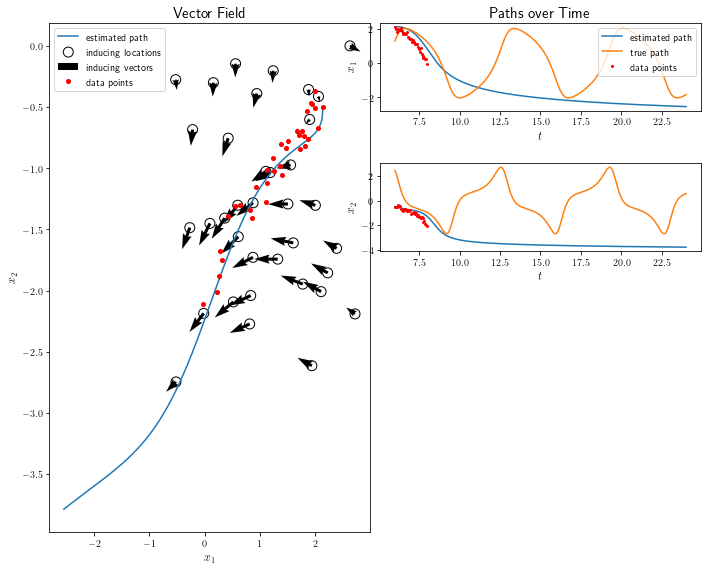

Calculating posterior covariance on target vs. inducing point.


In [67]:
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tbegin=6, tend=8, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

print("Calculating prior covariance on target vs. inducing point.")
prior_KTZ = get_covariance(npde, T).eval()

npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)


print("Calculating posterior covariance on target vs. inducing point.")
posterior_KTZ = get_covariance(npde, T).eval()

IG_6_8 = _get_IG(prior_KTZ, posterior_KTZ)

In [68]:
IG_6_8

1.2333959482094485

#### Restrict the start and end for time [6,8]

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         176.514
              50         112.587
             100          68.673
             150          27.705
             200          10.333
             250           7.216
             300           7.515
             350           4.712
             400           4.417
             450           4.034
             500           3.597
Optimization ends.
Plotting...
name:                  npode
noise variance:        [0.00980488 0.01281438]
signal variance:       1.4245263800757813
lengthscales:          [0.90263993 1.08284866]


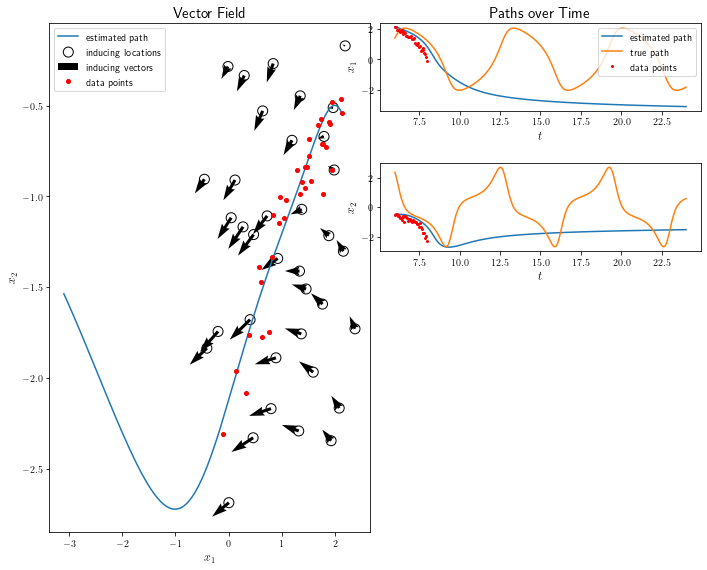

name:                  npode
noise variance:        [0.00980488 0.01281438]
signal variance:       1.4245263800757813
lengthscales:          [0.90263993 1.08284866]
RMSE over the dimensions is: 5.90737775596736
name:                  npode
noise variance:        [0.00980488 0.01281438]
signal variance:       1.4245263800757813
lengthscales:          [0.90263993 1.08284866]
RMSE over the dimensions is: 6.68431279289365


6.68431279289365

In [72]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tbegin=6, tend=8, nstd=0.1)

npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")
npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

eval_model(npde, t, Y, Nw=1)


eval_t = [np.linspace(0, 8, 50)]
eval_model(npde, eval_t, Y, Nw=1)

name:                  npode
noise variance:        [0.00980488 0.01281438]
signal variance:       1.4245263800757813
lengthscales:          [0.90263993 1.08284866]


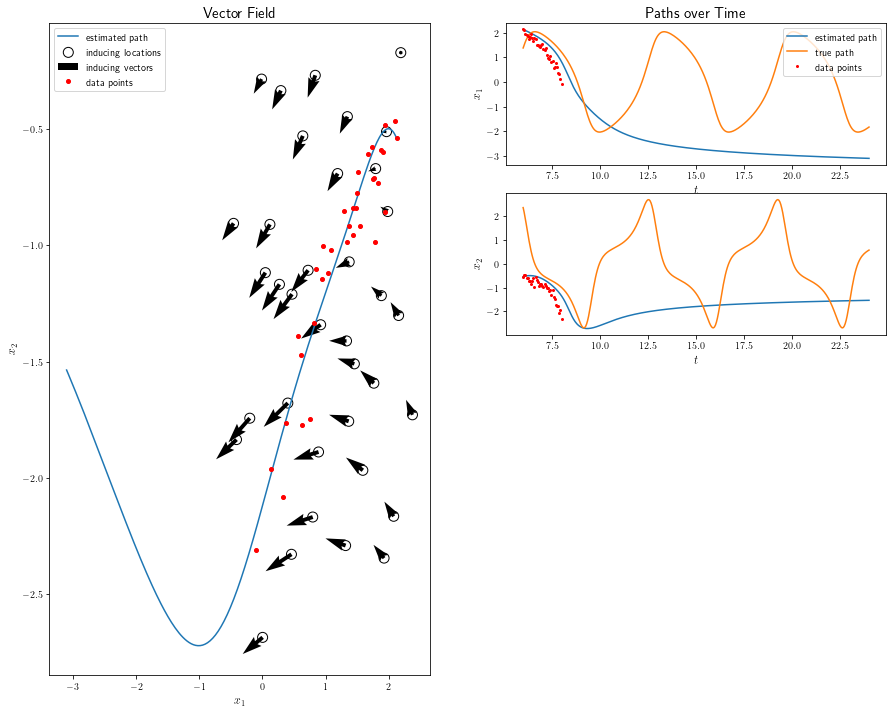

In [81]:
plot_model(npde,t,Y,Nw=1)

## 2. SDE with Constant Diffusion

### Data Generation

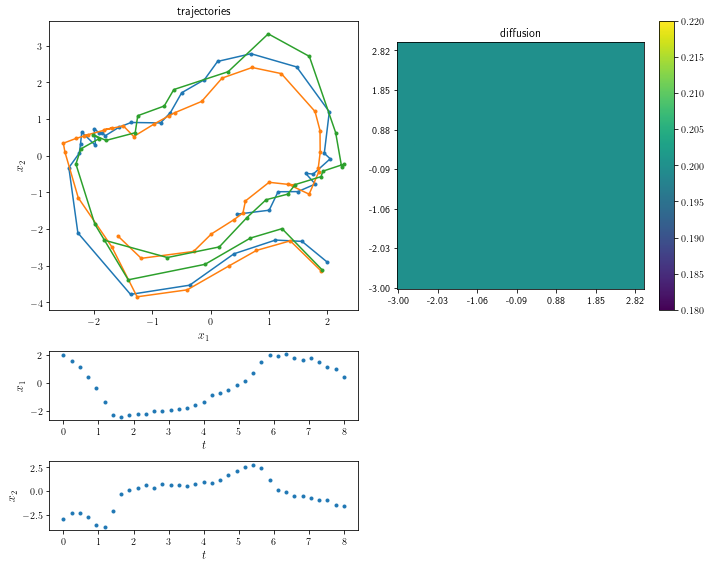

In [6]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[35,40,30], tend=8, nstd=0.1)

### Varying number of trajectories

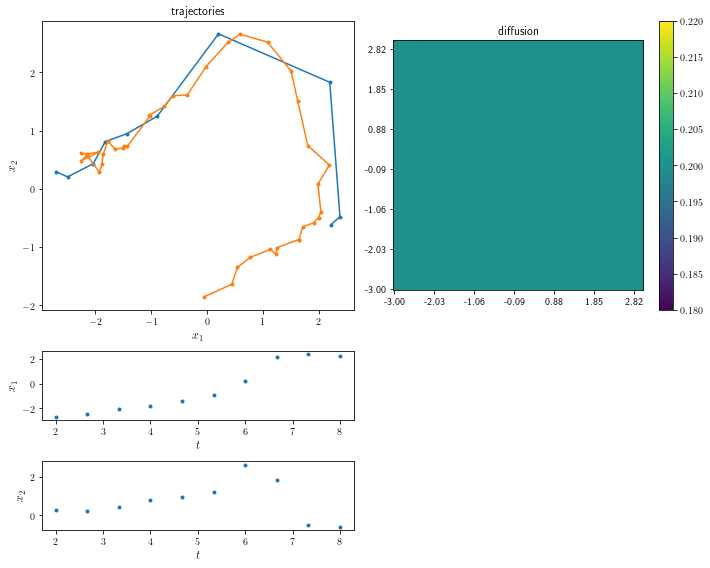

In [44]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[10, 40], tbegin=2, tend=8, nstd=0.1)

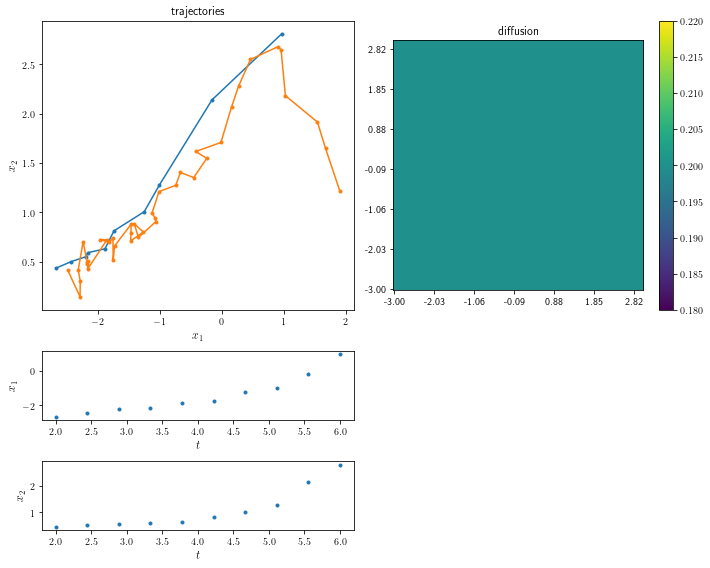

In [46]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[10, 40], tbegin=2, tend=6, nstd=0.1)

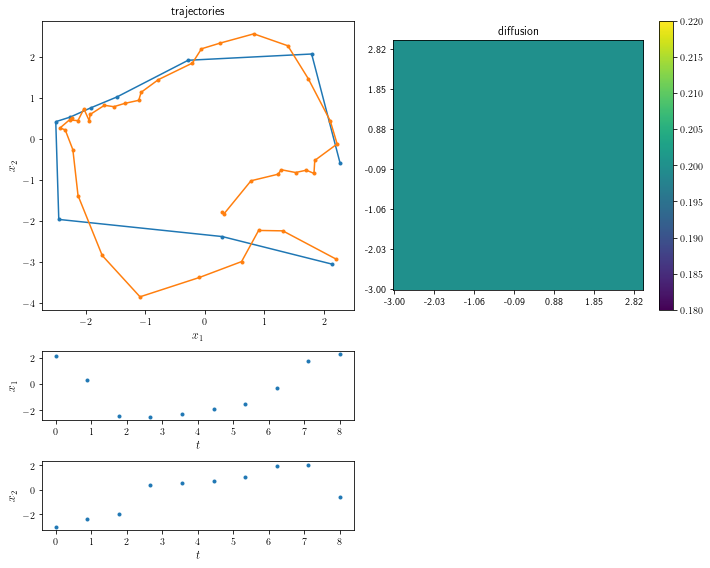

In [45]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[10, 40], tbegin=0, tend=8, nstd=0.1)

In [82]:
x0

array([[ 2.12577802, -0.54015827],
       [ 1.96534334, -0.62543577],
       [ 2.05378125, -0.42594215]])

### Inference

Model being initialized...
Building loss function...


Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         368.267
              50         264.509
             100         197.598
             150         178.582
             200         146.619
             250         175.416
             300         163.745
             350         171.477
             400         135.925
             450         162.296
             500         155.029
             550         150.822
             600         190.196
             650         136.355
             700         135.660
             750         296.771
             800         334.778
             850         268.862
             900         207.579
             950         174.083
            1000         146.981
Optimization ends.
Plotting...
noise variance:        [0.01556054 0.02637864]
signal variance:       1.8917819844961188
lengthscales:          [0.76690758 0.90430

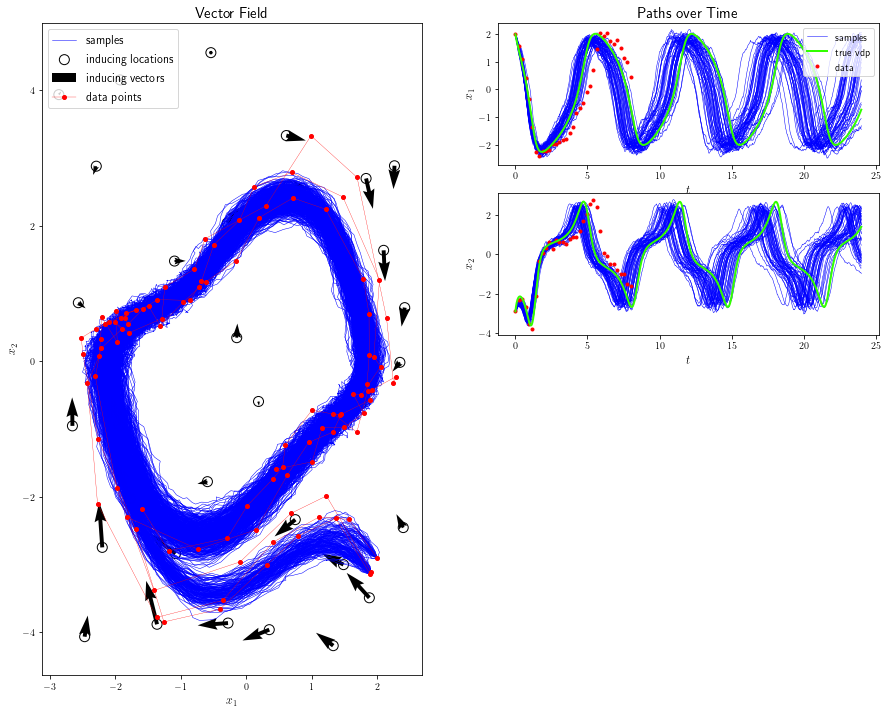

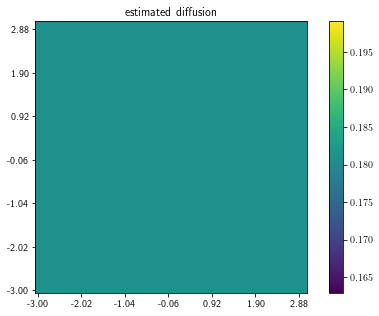

In [7]:
# in order to constant diffusion, lengthscale of the diffusion process (ellg0) must be initialized to a big number
npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1e5], ktype="id")
npde = fit_model(sess, npde, t, Y, Nw=100, num_iter=1000, print_every=50, eta=0.02, plot_=True)

### Predictions

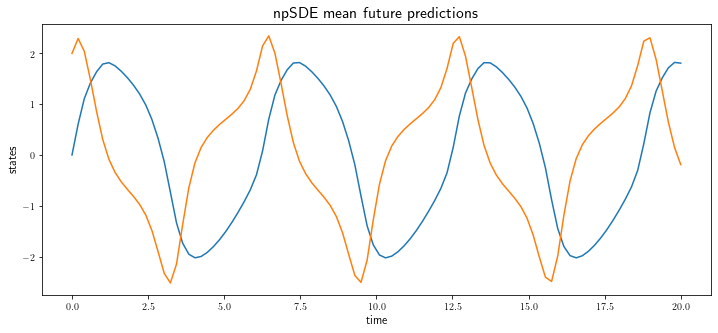

In [8]:
x0 = [0,2] # initial value
t = np.linspace(0,20,100) # time points 
path = npde.predict(x0,t)
path = sess.run(path)

plt.figure(figsize=(12,5))
plt.plot(t,path)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE mean future predictions',fontsize=16);

### Sampling

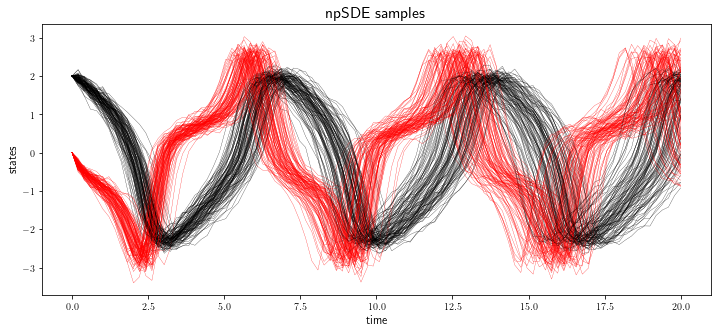

In [9]:
x0 = [2,0]
t = np.linspace(0,20,100)
Nw = 100 # number of samples
samples = npde.sample(x0,t,Nw=100)
samples = sess.run(samples)

plt.figure(figsize=(12,5))
for i in range(Nw):
    plt.plot(t,samples[i,:,0],'-k',linewidth=0.25)
    plt.plot(t,samples[i,:,1],'-r',linewidth=0.25)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE samples',fontsize=16);
plt.savefig('samples.png', dpi=200)

## 3. SDE with State Dependent Diffusion

### Data Generation

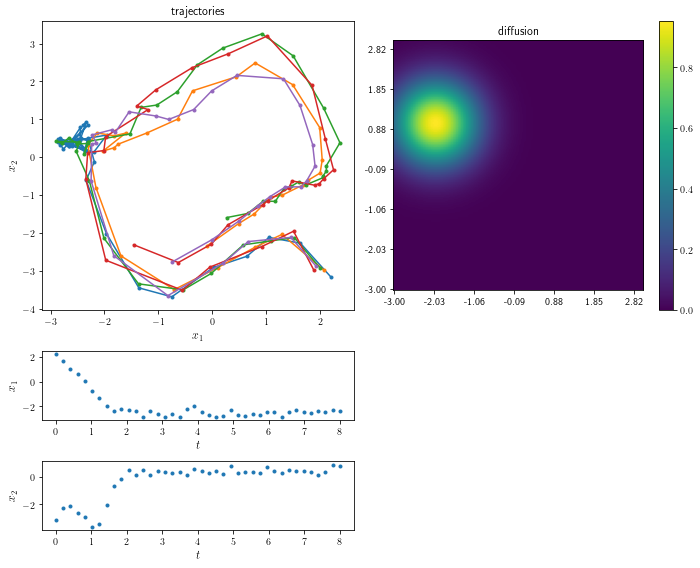

In [10]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-sdiff', Ny=[40,30,40,30,30], tend=8, nstd=0.1)

### Inference

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1        1013.757
              50         553.387
             100         485.299
             150         437.752
             200         469.594
             250         394.243
             300         395.085
             350         353.934
             400         354.872
             450         323.982
             500         351.321
             550         370.128
             600         378.235
             650         362.704
             700         297.861
             750         302.043
             800         283.009
             850         302.633
             900         296.724
             950         325.840
            1000         366.403
Optimization ends.
Plotting...
noise variance:        [0.03618574 0.03508207]
signal variance:       1.4457289387208858
lengthscales:          [0.86739789 1.0393713

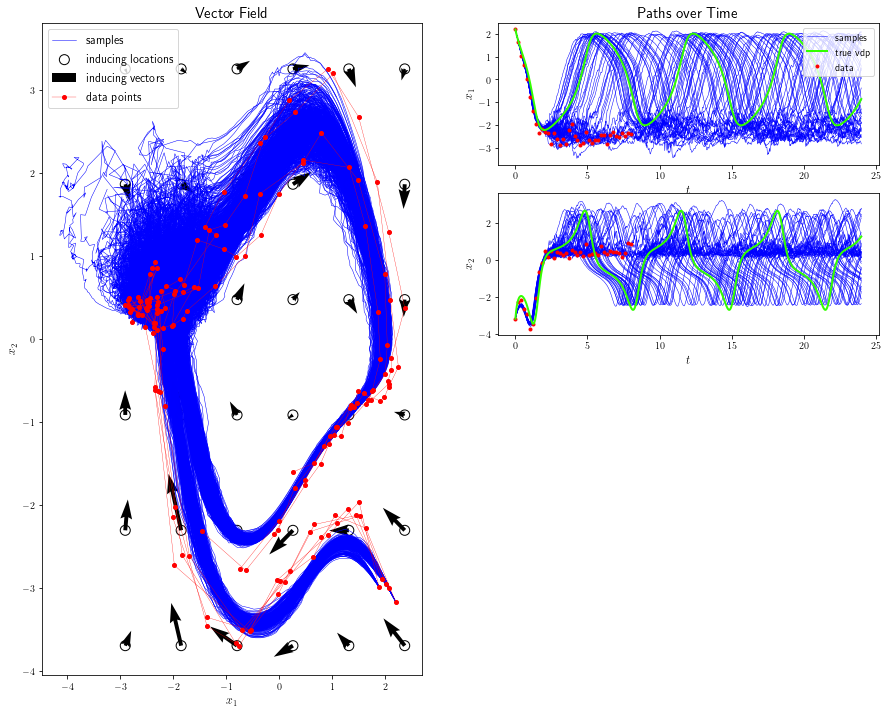

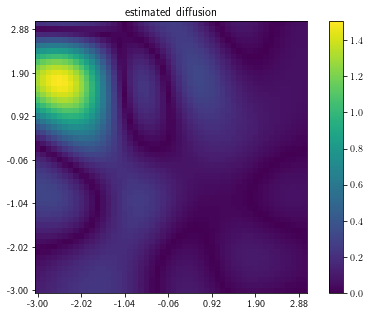

In [11]:
npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1.0], ktype="id", fix_Z=True)
npde = fit_model(sess, npde, t, Y, Nw=50, num_iter=1000, print_every=50, eta=0.01, plot_=True)

In [12]:
dir(npde)

['D',
 'Kzz',
 'U',
 'Z',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'build_prior',
 'diffus',
 'f',
 'fix_U',
 'fix_Z',
 'fix_sn',
 'forward',
 'g',
 'integrator',
 'jitter',
 'kern',
 'name',
 'predict',
 'sample',
 'sn',
 'whiten']

In [15]:
type(npde.Kzz), type(npde.U), type(npde.Z), type(npde.D)

(method,
 tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor,
 int)

In [18]:
dir(npde.kern)

['HessianCurlFree',
 'HessianDivergenceFree',
 'HessianIdentity',
 'K',
 'Kdiag',
 'Ksymm',
 'RBF',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'block',
 'ell',
 'fix_ell',
 'fix_sf',
 'ktype',
 'ndims',
 'sf',
 'square_dist',
 'tfblock']

In [22]:
x0

array([[ 2.19566574, -3.15912487],
       [ 2.07491766, -2.99070905],
       [ 2.00733013, -2.94228757],
       [ 1.88298463, -2.98285814],
       [ 1.93106577, -2.88882386]])

In [27]:
npde.kern.K(x0, x0).eval()

array([[2.09013216, 2.04298117, 1.99749385, 1.9306822 , 1.92877163],
       [2.04298117, 2.09013216, 2.08153658, 2.03952629, 2.05170431],
       [1.99749385, 2.08153658, 2.09013216, 2.06719003, 2.07931622],
       [1.9306822 , 2.03952629, 2.06719003, 2.09013216, 2.07839999],
       [1.92877163, 2.05170431, 2.07931622, 2.07839999, 2.09013216]])

In [55]:

eval_model(npde, t, Y, Nw=1)

name:                  npsde
noise variance:        [0.03618574 0.03508207]
signal variance:       1.4457289387208858
lengthscales:          [0.86739789 1.03937136]
diff signal variance:  1.0870484307851616
diff lengthscales:     [0.84120572]
[(1, 200, 2), (1, 200, 2)]
0 [4.90155538280609]
0 [5.038603165225497]
RMSE over the dimensions is: 2.4850396370078967


4.970079274015793